In [1]:
import sklearn
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score, validation_curve, learning_curve, ValidationCurveDisplay, LearningCurveDisplay
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, make_scorer
import matplotlib.pyplot as plt
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
rng=11

In [63]:
X_train = pd.read_parquet('data/X_pca.parquet')
X_test = pd.read_parquet('data/X_pca_test.parquet')

In [62]:
X_test.shape

(188533, 1)

In [3]:
y_train = pd.read_parquet('data/train.parquet')['price']
y_train.head()

0     4200
1     4999
2    13900
3    45000
4    97500
Name: price, dtype: int64

In [4]:
y = y_train.values.ravel()

In [5]:
X_train

,0
0,2.957834
1,1.557180
2,1.426272
3,-0.927851
4,-1.171073
...,...
188528,-0.335460
188529,-0.745114
188530,-1.045326
188531,-1.040406


In [6]:
estimator = MLPRegressor(max_iter=1000, random_state=rng, early_stopping=True)
param_name = "hidden_layer_sizes"

In [14]:
hidden_layer_sizes = {
    'one_layer': [(120,), (150,)],
    'two_layer_refined': [(20, 25), (25, 30), (15, 30)],
    'two_layer_complex': [(50, 50), (80, 80)],
    'three_layer': [(20, 30, 20), (30, 40, 30)],
    'varying_depth': [(30, 30), (30, 30, 30), (30, 30, 30, 30)]
}

param_range = [item for sublist in hidden_layer_sizes.values() for item in sublist]
# param_range = [(x,) for x in np.arange(10, 110, 10)]
param_range_str = [str(x) for x in param_range]

hidden_train_scores, hidden_valid_scores = validation_curve(estimator, X_train, y_train, param_name=param_name, param_range=param_range, cv=5, scoring=mse_scorer,n_jobs=-1)

/Users/nikhilkapila/miniconda3/envs/kaggle/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


UFuncTypeError: ufunc 'subtract' did not contain a loop with signature matching types (dtype('<U16'), dtype('<U16')) -> None

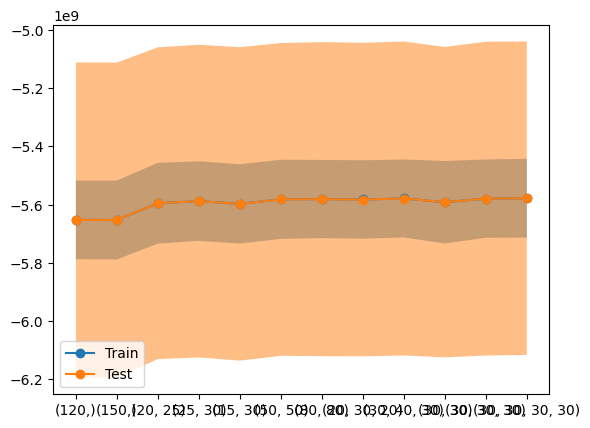

In [16]:
display = ValidationCurveDisplay(param_name=param_name, param_range=param_range_str,
                                 train_scores=hidden_train_scores, test_scores=hidden_valid_scores,
                                 score_name="mse")

param = { "line_kw" : {"marker":"o"}}
display.plot(**param)
plt.title(param_name + " - Wine Dataset ")
plt.xticks(param_range, labels=[f"{p:.1e}" for p in param_range])
plt.xticks(rotation=90)
plt.show()

In [17]:
mlp = MLPRegressor(hidden_layer_sizes=(120,), random_state=11, learning_rate_init=0.001, max_iter=1000, early_stopping=True)

In [18]:
mlp.fit(X_train, y)

MLPRegressor(early_stopping=True, hidden_layer_sizes=(120,), max_iter=1000,
             random_state=11)

In [68]:
pd.DataFrame(X_test['0'])

0         0.636300
1        -1.132939
2        -0.755051
3        -0.095265
4        -0.140224
            ...   
125685    0.343909
125686   -0.730859
125687    0.230795
125688    0.915052
125689    0.015877
Name: 0, Length: 125690, dtype: float64

In [69]:
preds = mlp.predict(pd.DataFrame(X_test['0']))

/Users/nikhilkapila/miniconda3/envs/kaggle/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


In [71]:
preds_df = pd.DataFrame(preds, columns=['price'])
preds_df

,price
0,14974.574473
1,75927.657522
2,62908.812139
3,40178.137210
4,41727.036141
...,...
125685,25047.905234
125686,62075.370065
125687,28944.847148
125688,5371.126697


In [72]:
preds_df['id'] = X_test['id']

In [77]:
preds_df

,price,id
0,14974.574473,188533
1,75927.657522,188534
2,62908.812139,188535
3,40178.137210,188536
4,41727.036141,188537
...,...,...
125685,25047.905234,314218
125686,62075.370065,314219
125687,28944.847148,314220
125688,5371.126697,314221


In [78]:
preds_df.to_csv('data/output.csv', index=False)